## Solving the GLM (the hard part)
GLMs are a tricky bunch. They _sound_ simple, but we're seeing in this series on GLMs that they aren't so easy to solve. In this third and final post on GLMs, we'll do some serious math to get a solution for GLMs, and then tidy things up and package it all into a nice little algorithm.

The [first post in this series](/glm-part-i) got us into the mindset of stating our goals and problems using a probabilistic framework. The [second post in this series](/glm-part-ii) extended that idea to cover a wide range of linear models, and presented the idea of a data generation process. We ended that post with a concrete mathematical problem that we needed to solve, but we did not solve it because we said it was too damn hard. This post will introduce a solution to that equation via the method of [_iteratively reweighted least squares_ (IRLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares). Finally, we'll package all that we've discussed up into a simple procedure for applying and solving GLMs.

## Solving for the regression coefficients via IRLS

### Quick tangent: exponential family mean and variance

For the derivations later on, two properties of exponential family distributions will prove quite important. For a random variable $Y$ that follows an exponential family distribution, we have:

$$
E\left[Y\right] = \mu = b'(\theta)\\
Var\left[Y\right] = \frac{\phi}{w} b''(\theta)
$$

A lot of texts gloss over these two equations, but they are not hard to prove. The proofs can be found at the end of this post in the appendix.

### The score equation
In the last post we wound up with the following equation, which we needed to solve to find the optimal regression coefficients:

$$
\vec{U}(\vec{\beta}) = \frac{1}{\phi} \left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right) \left[\vec{y} - \vec{\mu}\right] = \frac{1}{\phi} \left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right) \left[\vec{y} - g^{-1}(X \vec{\beta})\right] = \vec{0}
$$

The source of our troubles is that $\vec{\mu}$ is not necessarily a linear function of the inputs and when it is not, we will not have a closed form solution for $\vec{\beta}$. We begin to combat this issue by using an approximation of the $\vec{\mu}$ vector; specifically, we use a Taylor series approximation. 

### Taylor approximation

A Taylor series expansion is a way of approximating a function $f(x)$ in a region near a specific point in the function's domain $x_0$. With a Taylor series, we can trade off how good the approximation is with how complex the approximation is. If we use an infinite series of terms to approximate it, the estimate becomes arbitrarily good. If we only use a few terms for the approximation, then it is not as good, but remains simple and mathematically easy to analyze. Usually, a Taylor expansion is used to obtain a decent approximation of a function in a small region of the domain which is important to the problem. 

Consider the plot below. The function $f(x) = sin(x)$ is clearly a non-linear function, but in some small regions of the domain, near x = 0 for instance, the function behaves quite linearly. If we were faced with a problem where we knew that the region of the domain we cared about was near x = 0, then we could approximate $f(x) = sin(x)$ with just $f(x) = x$ without being too wrong. This is a property that we'll exploit with GLMs and the method of IRLS.

For more rigid mathematical treatment, see [here](http://www.sosmath.com/calculus/tayser/tayser01/tayser01.html) and [here](https://en.wikipedia.org/wiki/Taylor_series).

(-2, 2)

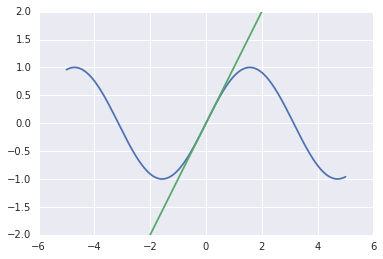

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.sin(x))
plt.plot(x, x)
plt.ylim([-2, 2])

### Expanding the score equation with a Taylor series

The expected value $\mu$ is a function of $\beta$, but is often times non-linear. We can approximate $\mu$ with a first-order Taylor expansion, but we should ask ourselves how good that approximation will actually be and if we can still live with the introduced error. Well, the Taylor expansion will be a good approximation in a small area around the point in the $\beta$ space which we do the approximation. Ideally, that point will be right around the optimal $\beta$ that we're looking for. The problem is that we don't know that optimal value of $\beta$ because that's what we're looking for in the first place! This seems like a circular problem: we need to know the best $\beta$, and to do that we need a good approximation of $\mu$, and to do that we need to know the best $\beta$, and to do that we need a good approximation of $\mu$, and to do that we...

Ok, you get it. Well, if you thought "I bet we can use an iterative procedure to solve this silly problem," then you were right! We'll use IRLS, which has "iterative" right in the damn name.

Roughly, we will start with some guess at the coefficients (hopefully an educated one), then we'll approximate $\mu$ in a region around that guess in coefficient space. We will then be able to solve the score equation for $\beta$, which will give us a _better_ or _improved_ value for the coefficients $\beta$. We can keep repeating until we converge to the optimal value.

### Deriving IRLS for GLMs

Let's get down to the math. First, guess a value for $\vec{\beta} = \hat{\beta}$. This implies a guess for $\vec{\eta} = \hat{\eta}$, which yields the following Taylor expansion.

$$
\vec{\mu}(\vec{\eta}) \approx \mu(\hat{\eta}) + \mu'(\hat{\eta})(\vec{\eta} - \hat{\eta})\\
\vec{\mu}(X\vec{\beta}) \approx g^{-1}(X \hat{\beta}) + \frac{\partial g^{-1}(\vec{\eta})}{\partial \vec{\eta}}\bigg|_{\hat{\eta}} \cdot (X\vec{\beta} - X\hat{\beta})\\
$$

We can rewrite the above equation as:

$$
\vec{\mu}(X\vec{\beta}) \approx \tilde{\mu} + W \cdot (X\vec{\beta} - X\hat{\beta})
$$

where $W$ is a diagonal matrix with $\frac{\partial g^{-1}(\vec{\eta})}{\partial \vec{\eta}}\bigg|_{\hat{\eta}}$ as its entries (this follows from the rules of matrix calculus - for a great review of this subject, [see here](http://www.colorado.edu/engineering/CAS/courses.d/IFEM.d/IFEM.AppF.d/IFEM.AppF.pdf)). Now, plug in this approximation for $\vec{\mu}$ to the score equation:

$$
\vec{U} = \frac{1}{\phi} \left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right) \left[\vec{y} - \tilde{\mu} + W \cdot (X\hat{\beta} - X\vec{\beta})\right]\\
= \frac{1}{\phi} \left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right) W \left[\vec{z} - X\vec{\beta}\right] \\ \text{where} \: \vec{z} = W^{-1}(\vec{y} - \tilde{\mu}) + X\vec{\beta}
$$

Alright, looking at this we can begin to see that things aren't so bad. The $W$ matrix (and therefore $W^{-1}$) is not hard to compute for almost all reasonable link functions. $\tilde{\mu}$ is simply a known function of the inputs and the guess of the regression coefficients $\hat{\beta}$. The only troubling term still left is $\left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right)$. Let's dissect it:

$$
\left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right) = \left(\frac{\partial \vec{\eta}}{\partial \vec{\beta}}\right) \left(\frac{\partial \vec{\theta}}{\partial \vec{\eta}}\right) 
$$

The $\frac{\partial \vec{\eta}}{\partial \vec{\beta}}$ term is easy:

$$
\eta = X\vec{\beta}\\
\frac{\partial \vec{\eta}}{\partial \vec{\beta}} = X^T
$$

Now consider just the $\left(\frac{\partial \vec{\theta}}{\partial \vec{\eta}}\right)$. Remembering that $\theta = h(\mu)$ and $\mu = g^{-1}(\eta)$, we have:

$$
\frac{\partial \theta}{\partial \eta} = \frac{\partial h(\mu)}{\partial \mu} \frac{\partial \mu}{\partial \eta} = \frac{\partial h(\mu)}{\partial \mu} \frac{\partial g^{-1}(\eta)}{\partial \eta}
$$

We can simplify the $\frac{\partial h(\mu)}{\partial \mu}$ term into a nicer form.

$$
\frac{\partial h(\mu)}{\partial \mu} = \frac{\partial \theta}{\partial \mu} \: \text{since} \: \theta = h(\mu)\\
= \frac{1}{\frac{\partial \mu}{\partial \theta}}\\
= \frac{1}{\frac{\partial b'(\theta)}{\partial \theta}} \: \text{since} \: \mu = b'(\theta)\\
= \frac{1}{b''(\theta)}\\
= diag\left(\frac{1}{Var[Y]\frac{1}{\phi}}\right)
$$

The variance for exponential family distributions is usually a function of the expected value $\mu$. So, we can write:

$$
\frac{\partial h(\mu)}{\partial \mu} = diag\left(\frac{1}{Var(\vec{\mu})\frac{1}{\phi}}\right)
$$

Let's go back for a minute now. We set out trying to tackle the term:

$$
\left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right) = \left(\frac{\partial \vec{\eta}}{\partial \vec{\beta}}\right) \left(\frac{\partial \vec{\theta}}{\partial \vec{\eta}}\right) 
$$

Using some simplfications we just made, that turns into:

$$
\frac{\partial \vec{\theta}}{\partial \vec{\beta}} = \left(X^T\right) \left(diag\left(\frac{1}{Var(\mu_i)\frac{1}{\phi}}\right) \cdot \frac{\partial g^{-1}(\vec{\eta})}{\partial \vec{\eta}}\right)
$$

Using a nifty rule of calculus [which is described here](http://oregonstate.edu/instruct/mth251/cq/Stage6/Lesson/inverseDeriv.html), we can simplify as follows:

$$
\frac{\partial g^{-1}(\eta)}{\partial \eta} = \frac{1}{\frac{\partial g(\mu)}{\partial \mu}}
$$

which gives us:

$$
\frac{\partial \vec{\theta}}{\partial \vec{\beta}} = \left(X^T\right) \left(diag\left(\frac{1}{Var(\mu_i)\frac{1}{\phi}}\right) \cdot diag\left(\frac{1}{\frac{\partial g(\mu)}{\partial \mu}}\right)\right)
$$

Now, we can bring this all the way back to the score equation.

$$
\vec{U} = \frac{1}{\phi} \left(\frac{\partial \vec{\theta}}{\partial \vec{\beta}}\right)W \left[\vec{z} - X\vec{\beta}\right]\\
= \frac{1}{\phi} \left(X^T diag\left(\frac{1}{Var(\mu_i)\frac{1}{\phi}}\right) \cdot diag\left(\frac{1}{\frac{\partial g(\mu)}{\partial \mu}}\right) \right) W \left[\vec{z} - X\vec{\beta}\right]\\
= \left(X^T diag\left(\frac{1}{Var(\mu_i)}\right) \cdot diag\left(\frac{1}{\frac{\partial g(\mu)}{\partial \mu}}\right) \right) W \left[\vec{z} - X\vec{\beta}\right]\\
$$

Remember from earlier that

$$
W = diag\left( \frac{\partial g^{-1}(\eta)}{\partial \eta} \right) = diag\left(\frac{1}{\frac{\partial g(\mu)}{\partial \mu}}\right)
$$

We can condense the three diagonal matrices above into one by defining a new variable:

$$
\tilde{W} = diag\left(\frac{1}{Var(\vec{\mu})} \frac{1}{\frac{\partial g(\mu)}{\partial \mu}}\right) W\\
= diag\left( \frac{1}{Var(\vec{\mu})} \frac{1}{\left(\frac{\partial g(\mu)}{\partial \mu}\right)^2}\right)
$$

This leaves us with, finally, a brand new form for the score equation:

$$
\vec{U}(\vec{\beta}) = X^T \tilde{W} \left[\vec{z} - X\vec{\beta}\right]
$$

**Pro Tip: this is the part where you get really excited.**

<img src="../../images/hooray_cat.jpg" width="400">

Whew. We just went through what seems like a ton of work to basically simplify/restate the original score equation. However, the form of the score equation written above is very nice to solve. This matches exactly the form of a [weighted least squares regression](https://en.wikipedia.org/wiki/Least_squares#Weighted_least_squares), regressing $X\vec{\beta}$ onto $\vec{z}$, with diagonal weight matrix $\tilde{W}$. This equation _does_ have a closed form solution:

$$
\vec{\beta}^* = \left(X^T\tilde{W}X\right)^{-1}X^T\tilde{W}\vec{z}
$$

This means that we are finally where we want to be! We now have a way to find the best regression coefficients $\vec{\beta}$ by solving the score equation using an approximation to the $\mu(\vec{\beta})$ function near some initial guess $\hat{\beta}$.

### The full IRLS algorithm

1. Choose an exponential family distribution for the outcome $y$
2. Choose a link function $g(\mu) = \eta$
3. Start with an initial guess for the expected value $\hat{\mu}$
4. Compute the linear predictor $\hat{\eta} = g(\mu)$
5. Fit a least squares model $\vec{\beta} = (X^TX)^{-1}X^T\hat{\eta}$
6. Repeat until convergence
    1. $\hat{\eta} = X\vec{\beta}$
    2. $\hat{\mu} = g^{-1}(\hat{\eta})$
    3. Compute the new weights $w_i = \frac{1}{Var(\mu_i) \cdot \left(\frac{\partial g(\mu_i)}{\partial \mu_i}\right)^2}$
    4. Compute the new response $z_i = \eta_i + (y_i - \mu_i) \cdot \frac{\partial g(\mu)}{\partial \mu}$
    5. Solve for the improved coefficients using a weighted least squares solver $\vec{\beta} = \left(X^T\tilde{W}X\right)^{-1}X^T\tilde{W}\vec{z}$
7. Return optimal coefficients $\vec{\beta}^* = \vec{\beta}$

## Putting it all together now

We've talked about a lot of things, introduced a boatload of notation, and done some pretty clever calculus. It is not hard to forget how each piece fits in the larger picture of solving a GLM, so we will now make an effort to put everything back together in one nice procedure.

Start by remembering why we use a GLM and what we hope to get out of it. Earlier in the series, we said:

>We want to use the data to find the process by which the data generates the outcome.

Which, through a series of logical deductions, we expanded to mean:

> We want to use a linear combination of our data to find the parameters of the exponential family distribution that maximize the likelihood of observing the outcome data in the training set.

We did this by stating what the likelihood function was and how it depends on the regression coefficients. We used calculus to come up with an equation that, if solved, would yield the optimal regression coefficients. We then derived the method of IRLS to find a way of solving that equation. 

Now, as a data scientist that has decided to use a GLM to solve a prediction problem, you can follow the procedure below.

1. Decide what exponential family distribution that the output $y$ is drawn from (e.g. the number of persons killed by mule or horse kicks in the Prussian army per year is a positive count variable, so choose Poisson)
2. Decide what link function to use (e.g. for a binary outcome, the expected value $\mu$ should be restricted to [0, 1], so choose $\eta = g(\mu) = log(\frac{\mu}{1 - \mu})$)
3. Use the IRLS algorithm to solve for the optimal regression coefficients $\vec{\beta}^*$

## Appendix: Exponential family mean and variance

We will show that, for a random variable $Y$ drawn from an exponential family distribution, the following holds:

$$
E\left[Y\right] = \mu = b'(\theta)\\
Var\left[Y\right] = \frac{\phi}{w} b''(\theta)
$$

Start by with the identity that any probability distribution must integrate to 1.

$$
\int f(y) \: dy= 1
$$

Now differentiate both sides w.r.t $\theta$.

$$
\frac{d}{d \theta} \int f(y) \: dy = 0\\
\int \left(\frac{d}{d \theta} f(y)\right) \: dy = 0\\
\int f(y) \frac{y - b'(\theta)}{\phi/w} \: dy = 0\\
\int f(y) \cdot y \: dy - b'(\theta) \int f(y) \: dy = 0\\
\int f(y) \cdot y \: dy = b'(\theta) \int f(y) \: dy
$$

Remember the definition for expected value: $E[Y] = \int f(y) \cdot y \: dy$. Also note the equality we started with: $\int f(y) \: dy = 1$. Substituting these equalities, we have:

$$
E[Y] = b'(\theta)
$$

We can perform a similar simplification for the variance:

$$
\int \left(\frac{d^2}{d \theta^2} f(y)\right) dy = 0\\
\int \frac{d}{d \theta} \left(f(y) \frac{y - b'(\theta)}{\phi/w}\right) dy = 0\\
\int f(y) \frac{-b''(\theta)}{\phi/w} \: dy + \int f(y) \left(\frac{y - b'(\theta)}{\phi/w}\right)^2 \: dy\\
\frac{-b''(\theta)}{\phi/w} \int f(y) \: dy + \frac{1}{\left(\phi/w\right)^2} \left[ \int f(y) y^2 \: dy - 2b'(\theta) \int f(y) y \: dy + b'(\theta)^2 \int f(y) \: dy \right]\\
\frac{-b''(\theta)}{\phi/w} + \frac{1}{\left(\phi/w\right)^2} \left[ E[Y^2] - 2b'(\theta) E[Y] + b'(\theta)^2 \right]\\
\frac{-b''(\theta)}{\phi/w} + \frac{1}{\left(\phi/w\right)^2} \left[ E[Y^2] - 2E[Y]^2 + E[Y]^2 \right]\\
\frac{-b''(\theta)}{\phi/w} + \frac{1}{\left(\phi/w\right)^2} Var[Y] = 0\\
Var[Y] = \frac{b''(\theta)}{w/\phi}
$$